# shift SRs EMD

**Goal:** In the 4b meeting, Sean suggested that the key issue for an `X_hh` categorization is *whether we trust the background or not* to this extent.

To answer this question, I'm proposed some new signal regions, but before actuallly *running* the reweighting, we thought maybe it might be judicious to check the 2b EMD masssplanes for these *new* SRs that we're proposing.

This notebook *directly* follows the procedure outlined in [Sean's talk](https://indico.cern.ch/event/1019894/contributions/4282081/attachments/2211653/3743092/EMD%20Mass%20Planes.pdf).

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance

import json
import tqdm
from itertools import product
from glob import glob
import uproot
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path+= ['../RRevolution/code/','../PAG-opt/','../code/',"../PyATLASstyle/"]
# from analysis import getXhh
# from utils import mcToYr, L

# from statUtils import calc_bstrap

from eventDisplays import rainbow_text

from plots import draw_SR, draw_VR, draw_CR

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


Note: this nb is looking for files that I have saved on the sl

In [2]:
yr = 17

In [4]:
figDir = f'figures/Xhh_val/data{yr}_nr_bkts'
if not os.path.exists(figDir):
    os.mkdir(figDir)


In [6]:
fDir = '../data/RR/nr_bkts/val_3bnotloose/'
fname = f'{fDir}/data{yr}_nr_bkts_sr_124_117.root'

f = uproot.open(fname)

FileNotFoundError: file not found

    '../data/RR/nr_bkts/val_3bnotloose//data17_nr_bkts_sr_124_117.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [12]:
# for k in f.keys():
#     print(k)

In [11]:
tname = 'fullmassplane'

qCols = ['quantile_h1_j1','quantile_h1_j2','quantile_h2_j1','quantile_h2_j2']
cols = ['m_h1','m_h2','ntag','X_wt_tag','m_hh'] + qCols

df = f[tname].arrays(cols,library='pd')

df['minQ'] = np.min(df[qCols],axis=1)

**The beginning of Sean's talk just compared the 2b distributions in the full massplane, so let's start w/ this!**

**Step 1:** Sanity check what I have is consistent w/ what 

In [31]:
# def EMD_2b(df,x,y):
#     '''
#     '''

In [19]:
x,y = 124, 117

In [32]:
nBins, r = 30, (50,200)

n_2b,ex,ey = np.histogram2d(*df.loc[df.ntag == 2,['m_h1','m_h2']].values.T,
                            [nBins]*2,[r]*2)
i_sr = np.digitize(x,ex)
j_sr = np.digitize(y,ey)

In [27]:
i_sr

15

In [25]:
ex[14],ex[15]

(120.0, 125.0)

In [34]:
mh1_mask = (df.m_h1 > ex[i_sr-1]) & (df.m_h1 < ex[i_sr])
mh2_mask = (df.m_h2 > ey[j_sr-1]) & (df.m_h2 < ey[j_sr])

center_mask = mh1_mask & mh2_mask & (df.ntag == 2)

u = df.loc[center_mask,'m_hh'].values

In [36]:
wdist = np.zeros_like(n_2b)

for i, (ex_min, ex_max) in tqdm(enumerate(zip(ex[:-1],ex[1:]))):
    for j, (ey_min, ey_max) in enumerate(zip(ey[:-1],ey[1:])):
        
        mh1_mask = (df.m_h1 > ex_min) & (df.m_h1 < ex_max)
        mh2_mask = (df.m_h2 > ey_min) & (df.m_h2 < ey_max)

        vary_mask = mh1_mask & mh2_mask & (df.ntag == 2)

        v = df.loc[vary_mask,'m_hh'].values
        
        wdist[i,j] = wasserstein_distance(u,v)



30it [06:53, 13.79s/it]


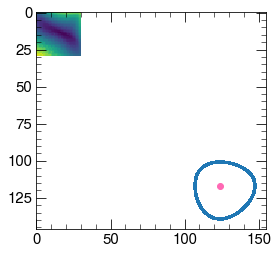

In [39]:
'''
WARNING - need to *sanity check* this code block tomorrow, since it's 
good to verify this imshow notation :D 
'''
plt.imshow(wdist,extent)

plt.scatter([x],[y],color='hotpink',marker='o')
xx,yy = draw_SR(x,y,'hotpink')
plt.plot(xx,yy,80,'hotpink')



In [40]:
?plt.imshow

**Now compare with Sean's #s**

In [15]:
sr0 = (70,66)
sr1 = (170,68)
sr2 = (170,160)
sr3 = (78,166)

c0, c1, c2, c3 = 'C0', 'C1', 'C2', 'C3'
cm0,cm1,cm2,cm3 = 'Blues','Oranges','Greens','Reds'

Oh - this nb would *also* be a great place to demonstrate that $\Delta \eta_{hh}$ and $m_{hh}$ are uncorrelated in our SR!

1. 2d histograms
2. EMD variation w/r.t. nominal?

Maybe w/ rw and not?